# Training a Multi-Turn Agent for Mathematical Reasoning with End-to-End Reinforcement Learning in AReaL

This notebook utilizes components provided by AReaL to quickly set up a multi-turn agent for mathematical reasoning and train the agent through end-to-end reinforcement learning.

This agent solves mathematical problems, e.g. GSM8K, through step-by-step reasoning.

The following code blocks primarily include the following steps:

1. **Experiment Preparation:** Load experiment configuration from YAML, configure environment variables, start the SGLang server, and load the GSM8K dataset.

2. **Define a Simple Single-Turn Generation Workflow.**

3. **Modify the Single-Turn Workflow into a Multi-Turn Workflow**, allowing different numbers of rounds per data instance.

4. **Generate a Group of Multi-Turn Trajectories Each Time** (i.e., GRPO).

5. **Test the Multi-Turn Workflow.**

6. **Integrate the Workflow into End-to-End GRPO Reinforcement Learning Training.**

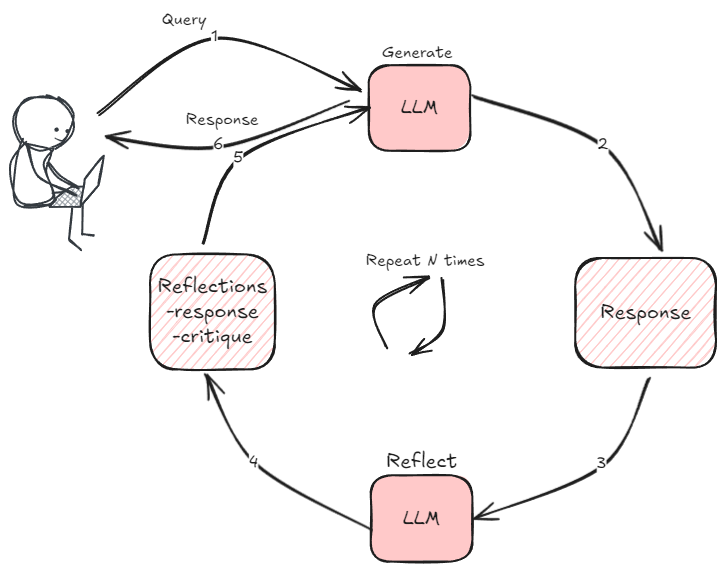

In [ ]:
# Configure the Experiment Environment
!pip install -e .[all]

## Experimental Preparation

### Load Experiment Configuration

The following code loads a pre-defined YAML experiment configuration template for GSM8K GRPO through `load_expr_config`.

This template sets up hyper-parameters including optimizer, model, learning rate, and so on. 


In [ ]:
from dataclasses import asdict, dataclass

from areal.api.cli_args import GRPOConfig, load_expr_config

args = ["--config", "examples/math/gsm8k_grpo.yaml"]
config, _ = load_expr_config(args, GRPOConfig)
config: GRPOConfig

### Environment Variable

We specify the IP address and ports for SGLang servers and PyTorch distributed training through corresponding environment variables.

These environment variables will be loaded when the AReaL engines (rollout/training) are initialized.


***When launching experiments through AReaL launchers instead of jupyter notebook, these environment variables will be set by the launcher by default and are unnecessary to be set by the users.***

In [ ]:
from areal.utils.network import find_free_ports

SGLANG_PORT, MASTER_PORT = 11451, 14514

SGLANG_HOST = "127.0.0.1"

# Environment variables used by inference/train engines
import os

os.environ["AREAL_LLM_SERVER_ADDRS"] = f"{SGLANG_HOST}:{SGLANG_PORT}"
os.environ["MASTER_ADDR"] = "127.0.0.1"
os.environ["MASTER_PORT"] = str(MASTER_PORT)
os.environ["RANK"] = str(0)
os.environ["WORLD_SIZE"] = str(1)
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["LOCAL_RANK"] = str(0)
os.environ["NCCL_CUMEM_ENABLE"] = "0"
os.environ["NCCL_NVLS_ENABLE"] = "0"

### Launch SGLang Server

AReaL seperates trajectory rollouts from training, where rollouts and training are executed asynchronously, allowing for full GPU utilizing and fast end-to-end training.

In this example, the reinforcement learning algorithm (GRPO) runs on GPU 0.

In GPU 1, an inference service is launched for LLM generation. The RL algorithm can send generation request to the inference service.

The following code launches a SGLang server on GPU 1.

In [ ]:
import subprocess
import sys

# launch sglang server
from areal.api.cli_args import SGLangConfig
from areal.utils.network import find_free_ports

config.sglang.log_level = "info"
config.sglang.decode_log_interval = 10
sglang_cmd = SGLangConfig.build_cmd(
    config.sglang,
    tp_size=1,
    base_gpu_id=1,
    host=SGLANG_HOST,
    port=SGLANG_PORT,
)
sglang_process = subprocess.Popen(
    sglang_cmd,
    stdout=sys.stdout,
    stderr=sys.stderr,
)

### Load GSM8k Dataset

Load GSM8k dataset using Huggingface `datasets` package.

In [ ]:
# load gsm8k dataset
from datasets import load_dataset

dataset = load_dataset(path="openai/gsm8k", name="main", split="train")
print(f">>> dataset column names: {dataset.column_names}")
print(f">>> example data: {dataset[0]}")

### Load Necessary Python Packages and Modules

In [ ]:
import asyncio
import functools
import os
import time
import uuid

import colorama
import torch
from transformers import AutoTokenizer, PreTrainedTokenizerFast

from areal.api.cli_args import GenerationHyperparameters
from areal.api.engine_api import InferenceEngine
from areal.api.io_struct import (
    AllocationMode,
    FinetuneSpec,
    ModelRequest,
    WeightUpdateMeta,
)
from areal.api.workflow_api import RolloutWorkflow
from areal.engine.ppo.actor import FSDPPPOActor
from areal.engine.sglang_remote import RemoteSGLangEngine
from areal.utils.data import concat_padded_tensors, tensor_container_to
from areal.utils.device import log_gpu_stats

tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

Process the data format into a compatible chat format for OpenAI client.

In [ ]:
def process(sample):
    messages = [{"role": "user", "content": sample["question"]}]
    return {"messages": messages}


dataset = dataset.map(process).remove_columns(["question"])
print(f">>> example data: {dataset[0]}")

In [ ]:
from torchdata.stateful_dataloader import StatefulDataLoader

dataloader = StatefulDataLoader(
    dataset,
    batch_size=config.train_dataset.batch_size,
    shuffle=True,
    collate_fn=lambda x: x,
    drop_last=True,
)
from itertools import cycle

data_generator = cycle(dataloader)

ft_spec = FinetuneSpec(
    total_train_epochs=config.total_train_epochs,
    dataset_size=len(dataloader) * config.train_dataset.batch_size,
    train_batch_size=config.train_dataset.batch_size,
)

x = next(data_generator)
print(f">>> The type of a batch is: {type(x)}\n")
print(f">>> Each piece of data has keys: {x[0].keys()}\n")
print(f">>> Example rollout input: {x[0]['messages']}\n")

## A Simple Single-Turn Workflow

A single-turn workflow utilizes the inference engine to generate a response for a answer, and uses a reward function to compute the reward.

### Reward Function

In [ ]:
from concurrent.futures import ProcessPoolExecutor

rw_executor = ProcessPoolExecutor(max_workers=4)

from areal.reward.math_parser import extract_answer, math_equal

REWARD_TIMEOUT_SECONDS = 15


def reward_fn(generated, answer):
    try:
        x = extract_answer(generated, "math", use_last_number=True)
        y = extract_answer(answer, "math", use_last_number=True)

        if x is None or x.strip() in ["None", "none", ""]:
            return 0.0
        elif y is None or y.strip() in ["None", "none", ""]:
            return 0.0
        return float(math_equal(x, y, timeout=False))
    except:
        return 0.0


# TODO: examine reward function
reward_fn(
    "\boxed{72}",
    "Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72",
)

### Single-Turn Workflow

The single-turn workflow is also called *Reinforcement Learning from Verifiable Rewards, RLVR*.

A RLVR workflow is extremely clean:

1. Load a datapoint from the dataset;
2. Call the inference engine to generate a response;
3. Compute reward using the reward function.

In [ ]:
# TODO: implement


class RLVRWorkflow:
    def __init__(self, gconfig, verbose):
        self.gconfig = gconfig
        self.verbose = verbose

    async def gen(self, engine, input_ids, rid, answer):
        req = ModelRequest(rid=rid, input_ids=input_ids, gconfig=self.gconfig)
        resp = await engine.agenerate(req)
        loop = asyncio.get_event_loop()
        completions_str = tokenizer.decode(resp.output_tokens)
        reward = await loop.run_in_executor(
            rw_executor, functools.partial(reward_fn, completions_str, answer)
        )
        if self.verbose:
            print(f">>> prompt str: {tokenizer.decode(resp.input_tokens)}")
            print(f">>> generated: {tokenizer.decode(resp.output_tokens)}")
            print(f">>> answer: {answer}")
            print(f">>> reward: {reward}")
        return resp, reward

    async def arun_episode(self, engine, data):
        assert self.gconfig.n_samples == 1
        prompt_ids = tokenizer.apply_chat_template(
            data["messages"],
            apply_chat_template=True,
            tokenize=True,
        )
        resp, reward = await self.gen(
            engine, prompt_ids, uuid.uuid4().hex, data["answer"]
        )
        input_ids = resp.input_tokens + resp.output_tokens
        logprobs = [0.0] * resp.input_len + resp.output_logprobs
        loss_mask = [0] * resp.input_len + [1] * resp.output_len

        res = dict(
            input_ids=torch.tensor(input_ids),
            logprobs=torch.tensor(logprobs),
            loss_mask=torch.tensor(loss_mask),
            reward=torch.tensor(reward),
            attention_mask=torch.ones(len(input_ids)),
        )
        # [bs, seqlen]
        res = {k: v.unsqueeze(0) for k, v in res.items()}
        return res

### Test Single-Turn Workflow

1. Create the inference engine;
2. Create the workflow;
3. Collect a batch of data using the inference engine and workflow.

In [ ]:
# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()
try:
    # TODO: create workflow
    workflow = RLVRWorkflow(
        gconfig=GenerationHyperparameters(max_new_tokens=512), verbose=True
    )
    sample_data = next(data_generator)[:2]
    res = rollout.rollout_batch(sample_data, workflow=workflow)
    print(res)
finally:
    rollout.destroy()

## Extending Single-Turn Workflow into Multi-Turn Reflection Workflow

The core logic: a while loop is executed that, when the LLM produces an incorrect answer, a prompt is injected to ask the LLM to reflect and generate the next answer.

To avoid the LLM from endless reflection, a discount factor should be added to multi-turn reward.

### Reflection Prompt

Since there may exist inconsistency of token ids when encoding and decoding a sequence, we need to tokenize the reflection prompt in advance and add the token ids of the reflection prompt into the trajectory during execution.

In [ ]:
messages = [{"role": "assistant", "content": "some random message."}]
prefix = tokenizer.apply_chat_template(messages, tokenize=False)
s1 = tokenizer.apply_chat_template(messages, tokenize=True)
messages += [
    {
        "role": "user",
        "content": "\nYour answer is either wrong or not parsable to the reward function. Please try to answer it again.",
    }
]
s2 = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)
s = tokenizer.apply_chat_template(messages, tokenize=False)
reflection_tokens = s2[len(s1) :]
print(f">>> prefix string:\n{prefix}\n")
print(f">>> prefix token id:\n{s1}\n")
print(f">>> whole string:\n{s}\n")
print(f">>> whole sentence token id:\n{s2}\n")

In [ ]:
class ReflectionWorkflow:
    def __init__(self, gconfig, max_turns, turn_discount, verbose=False):
        self.gconfig = gconfig
        self.max_turns = max_turns
        self.turn_discount = turn_discount
        self.verbose = verbose

    async def arun_episode(self, engine: InferenceEngine, data):
        messages = data["messages"]
        # Convert the prompt into input_ids
        input_ids = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
        )
        assert self.gconfig.n_samples == 1
        t = reward = 0
        discount = 1
        rid = uuid.uuid4().hex
        seq = []
        logprobs = []
        loss_mask = []
        # TODO: implement reflection
        while t < self.max_turns and reward == 0:
            resp, reward = await RLVRWorkflow(self.gconfig, self.verbose).gen(
                engine, input_ids, rid, data["answer"]
            )
            input_len = resp.input_len - len(seq)
            seq += resp.input_tokens[-input_len:] + resp.output_tokens
            logprobs += [0.0] * input_len + resp.output_logprobs
            loss_mask += [0] * input_len + [1] * resp.output_len
            t += 1
            if reward == 0:
                input_ids += resp.output_tokens
                if input_ids[-1] != tokenizer.eos_token_id:
                    input_ids += [tokenizer.eos_token_id]
                input_ids += reflection_tokens
                discount *= self.turn_discount

        res = dict(
            input_ids=torch.tensor(seq),
            logprobs=torch.tensor(logprobs),
            loss_mask=torch.tensor(loss_mask),
            rewards=torch.tensor(float(reward * discount)),
            attention_mask=torch.ones(len(seq), dtype=torch.bool),
        )
        res = {k: v.unsqueeze(0) for k, v in res.items()}
        return res

### Test Multi-Turn Reflection Workflow

In [ ]:
# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()
try:
    # create workflow
    workflow = ReflectionWorkflow(
        gconfig=GenerationHyperparameters(n_samples=1, max_new_tokens=512),
        max_turns=5,
        turn_discount=0.9,
        verbose=True,
    )
    sample_data = next(data_generator)[:2]
    res = rollout.rollout_batch(sample_data, workflow=workflow)
    print(res)
finally:
    rollout.destroy()

## Generate Multiple Trajectories for A Single Question

RL algorithms such as GRPO generate a group of multiple trajectories for each single question.

In the workflow, we can efficiently generate multiple trajectories by using `asyncio` to pose multiple generation request to the inference engine concurrently.

In [ ]:
class GroupedReflectionWorkflow:
    def __init__(self, gconfig, max_turns, turn_discount, verbose=False):
        self.gconfig = gconfig
        self.max_turns = max_turns
        self.turn_discount = turn_discount
        self.verbose = verbose

    async def arun_episode(self, engine, data):
        workflows = [
            ReflectionWorkflow(
                self.gconfig.new(n_samples=1),
                self.max_turns,
                self.turn_discount,
                self.verbose,
            )
            for _ in range(self.gconfig.n_samples)
        ]
        tasks = [workflow.arun_episode(engine, data) for workflow in workflows]
        results = await asyncio.gather(*tasks)
        return concat_padded_tensors(results)

In [ ]:
# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()
try:
    # create workflow
    workflow = GroupedReflectionWorkflow(
        gconfig=GenerationHyperparameters(n_samples=3, max_new_tokens=512),
        max_turns=5,
        turn_discount=0.9,
        verbose=False,
    )
    sample_data = next(data_generator)[:2]
    res = rollout.rollout_batch(sample_data, workflow=workflow)
    print(res)
finally:
    rollout.destroy()

## Integrating the Workflow into RL Training 


We've already tested the inference workflow. Next, we need to integrate this workflow into the training process.

This requires creating a separate training engine specifically for PPO. Within the training loop, inference and training are called.

### Synchronous Training

In [ ]:
allocation_mode=AllocationMode.from_str("sglang:d1p1t1+d1p1t1")
parallel_strategy = allocation_mode.train

# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize(train_data_parallel_size=parallel_strategy.dp_size)
workflow = GroupedReflectionWorkflow(
    gconfig=GenerationHyperparameters(n_samples=3, max_new_tokens=512),
    max_turns=5,
    turn_discount=0.9,
    verbose=False,
)

actor = FSDPPPOActor(config=config.actor)
actor.create_process_group(parallel_strategy=parallel_strategy)
actor.initialize(None, ft_spec)

rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()

weight_update_meta = WeightUpdateMeta.from_fsdp_xccl(
    allocation_mode
)
actor.connect_engine(rollout, weight_update_meta)

warmup_steps = 1
times = []
for global_step in range(5):
    if global_step >= warmup_steps:
        tik = time.perf_counter()
    batch = actor.rollout_batch(next(data_generator), 
                    granularity=actor.config.group_size,
                    workflow=workflow,
                    should_accept_fn=lambda sample: True,)
    
    logp = actor.compute_logp(batch)
    batch["prox_logp"] = logp

    actor.compute_advantages(batch)

    actor.ppo_update(batch)
    actor.step_lr_scheduler()

    rollout.pause()
    actor.update_weights(weight_update_meta)
    rollout.resume()
    
    actor.set_version(global_step + 1)
    rollout.set_version(global_step + 1)
    
    if global_step >= warmup_steps:
        times.append(time.perf_counter() - tik)
print(times)

### Asynchronous Training

In [ ]:
# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize(train_data_parallel_size=parallel_strategy.dp_size)
workflow = GroupedReflectionWorkflow(
    gconfig=GenerationHyperparameters(n_samples=3, max_new_tokens=512),
    max_turns=5,
    turn_discount=0.9,
    verbose=False,
)

actor = FSDPPPOActor(config=config.actor)
actor.create_process_group(parallel_strategy=parallel_strategy)
actor.initialize(None, ft_spec)

rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()

weight_update_meta = WeightUpdateMeta.from_fsdp_xccl(
    allocation_mode
)
weight_update_meta.nccl_group_name = "group2"

actor.connect_engine(rollout, weight_update_meta)

warmup_steps = 1
times = []
for global_step in range(5):
    if global_step >= warmup_steps:
        tik = time.perf_counter()
    batch = actor.prepare_batch(dataloader, 
                    granularity=actor.config.group_size,
                    workflow=workflow,
                    should_accept_fn=lambda sample: True,)
    
    logp = actor.compute_logp(batch)
    batch["prox_logp"] = logp

    actor.compute_advantages(batch)

    actor.ppo_update(batch)
    actor.step_lr_scheduler()

    rollout.pause()
    actor.update_weights(weight_update_meta)
    rollout.resume()
    
    actor.set_version(global_step + 1)
    rollout.set_version(global_step + 1)
    
    if global_step >= warmup_steps:
        times.append(time.perf_counter() - tik)
print(times)


In [ ]:
import signal as signal_module

import psutil


def terminate_process_and_children(pid: int, signal=None):
    if signal is None:
        signal = signal_module.SIGKILL
    if isinstance(signal, str):
        signal = getattr(signal_module, signal)
    try:
        parent = psutil.Process(pid)
        children = parent.children(recursive=True)
        for child in children:
            terminate_process_and_children(child.pid)
        parent.send_signal(signal)
    except psutil.NoSuchProcess:
        pass


terminate_process_and_children(sglang_process.pid)

In [ ]:
rollout.destroy()

In [ ]:
actor.destroy()

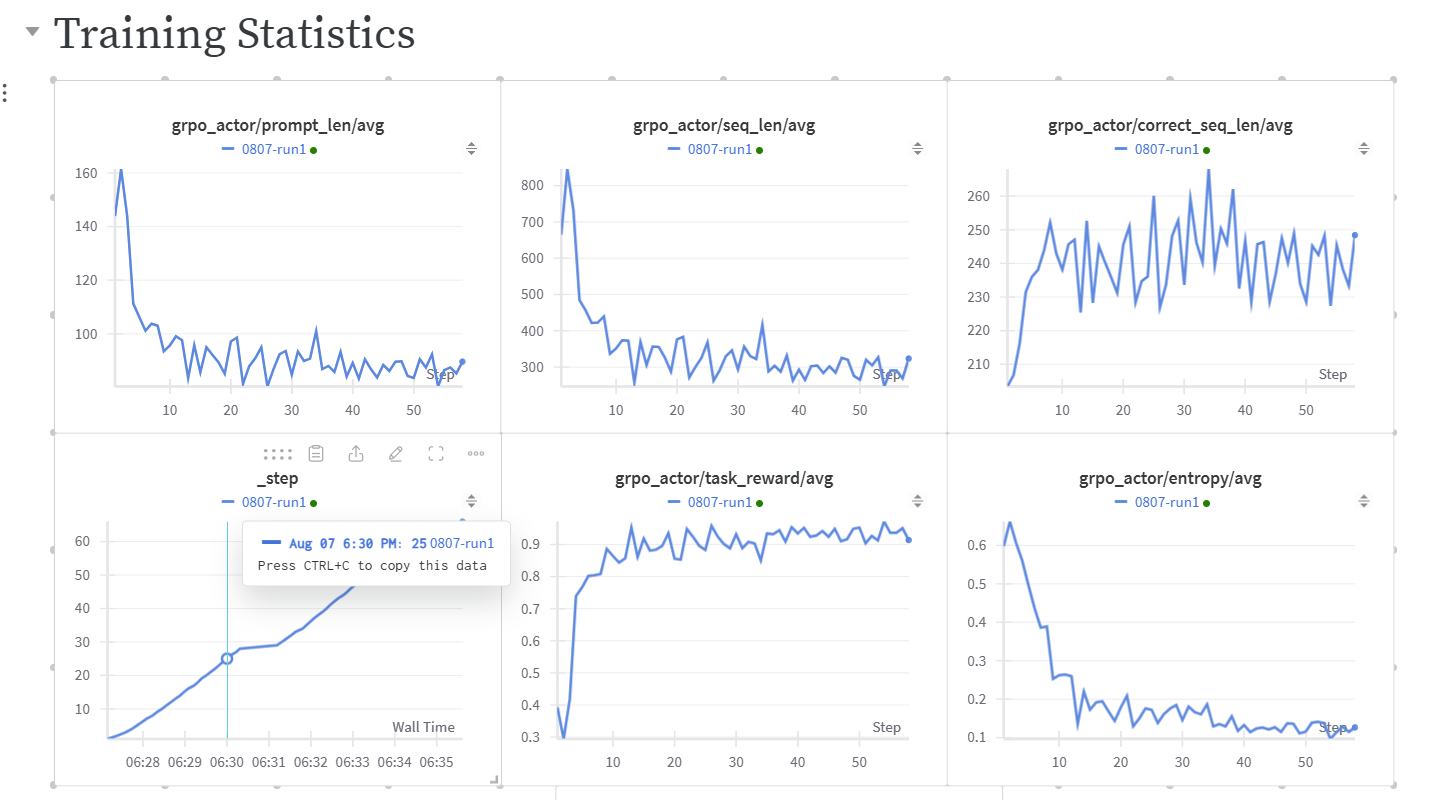